In [7]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from pathlib import Path

import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ttest_ind_from_stats
from statsmodels.regression.mixed_linear_model import MixedLM

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
base_path_data = '../Data'
base_path_results = '../results'

In [3]:
hup_univar_feats_reg = pd.read_csv(os.path.join(base_path_results, 'hup_univar_feats_reg.csv'))
mni_univar_feats_reg = pd.read_csv(os.path.join(base_path_results, 'mni_univar_feats_reg.csv'))

GLOBAL COMPARISON

In [24]:
def compare_sites_globally(hup_region_features, mni_region_features):
    """
    Perform global comparison between HUP and MNI cohorts
    
    Statistical methodology:
    1. For each feature, aggregate all measurements across all regions
    2. Use mixed-effects model to account for patient and region dependencies
    3. Alternative simpler approach: Average across regions first, then compare cohorts
    """
    results = []
    
    # Get features columns (ending with _mean)
    features = [col for col in hup_region_features.columns 
               if col.endswith('_mean')]
    
    for feature in features:
        # Method 1: Simple approach - average across regions first
        hup_patient_means = hup_region_features.groupby('patient_id')[feature].mean()
        mni_patient_means = mni_region_features.groupby('patient_id')[feature].mean()
        
        # Test for normality of patient-level distributions
        _, hup_p = stats.shapiro(hup_patient_means)
        _, mni_p = stats.shapiro(mni_patient_means)
    
        
        # Choose appropriate test for cohort comparison
        if hup_p > 0.05 and mni_p > 0.05:
            stat, p_val = stats.ttest_ind(hup_patient_means, mni_patient_means)
            test_name = "t-test"
        else:
            stat, p_val = stats.mannwhitneyu(hup_patient_means, mni_patient_means, 
                                           alternative='two-sided')
            test_name = "Mann-Whitney U"
        
        # Calculate effect size (Cohen's d)
        effect_size = (np.mean(hup_patient_means) - np.mean(mni_patient_means)) / \
                     np.sqrt((np.var(hup_patient_means) + np.var(mni_patient_means)) / 2)
        
        results.append({
            'feature': feature,
            'test': test_name,
            'statistic': stat,
            'p_value': p_val,
            'effect_size': effect_size,
            'hup_mean': np.mean(hup_patient_means),
            'mni_mean': np.mean(mni_patient_means),
            'hup_std': np.std(hup_patient_means),
            'mni_std': np.std(mni_patient_means),
            'hup_patients': len(hup_patient_means),
            'mni_patients': len(mni_patient_means)
        })
    
    results_df = pd.DataFrame(results)
    
    # Multiple comparison corrections
    results_df['p_value_bonferroni'] = np.minimum(
        results_df['p_value'] * len(results_df), 1)
    _, fdr_corrected = fdrcorrection(results_df['p_value'])
    results_df['p_value_fdr'] = fdr_corrected
    
    return results_df

y_ijk = β₀ + β₁(site) + u_i(patient) + v_j(region) + ε_ijk

where:
- y_ijk: measurement for patient i, region j, observation k
- β₀: overall intercept
- β₁: fixed effect of site
- u_i: random effect for patient i
- v_j: random effect for region j
- ε_ijk: residual error

In [25]:
def compare_sites_with_mixed_effects(hup_region_features, mni_region_features, feature):
    """
    Compare sites using mixed effects model with proper data formatting
    """
    # Combine data
    hup_data = hup_region_features[['patient_id', 'roi', feature]].copy()
    hup_data['site'] = 0  # Encode HUP as 0
    mni_data = mni_region_features[['patient_id', 'roi', feature]].copy()
    mni_data['site'] = 1  # Encode MNI as 1
    
    combined_data = pd.concat([hup_data, mni_data])
    
    # Ensure numeric data types
    combined_data[feature] = pd.to_numeric(combined_data[feature])
    combined_data['site'] = pd.to_numeric(combined_data['site'])
    
    try:
        # Fit mixed effects model
        md = MixedLM(endog=combined_data[feature],
                     exog=combined_data[['site']],
                     groups=combined_data['patient_id'])
        
        mdf = md.fit()
        return mdf.pvalues['site'], mdf.params['site']
    
    except Exception as e:
        print(f"Error in mixed effects model for {feature}: {str(e)}")
        return np.nan, np.nan

In [26]:
def compare_sites_globally_robust(hup_region_features, mni_region_features):
    """
    Perform robust global comparison between sites
    """
    results = []
    features = [col for col in hup_region_features.columns if col.endswith('_mean')]
    
    for feature in features:
        # Get patient-level means
        hup_means = hup_region_features.groupby('patient_id')[feature].mean()
        mni_means = mni_region_features.groupby('patient_id')[feature].mean()
        
        # Perform Mann-Whitney U test (non-parametric)
        stat, p_val = stats.mannwhitneyu(hup_means, mni_means, alternative='two-sided')
        
        # Calculate effect size (Cliff's Delta - non-parametric effect size)
        effect_size = (np.mean(hup_means) - np.mean(mni_means)) / \
                     np.sqrt((np.var(hup_means) + np.var(mni_means)) / 2)
        
        results.append({
            'feature': feature,
            'p_value': p_val,
            'effect_size': effect_size,
            'hup_mean': np.mean(hup_means),
            'mni_mean': np.mean(mni_means),
            'hup_std': np.std(hup_means),
            'mni_std': np.std(mni_means),
            'hup_n': len(hup_means),
            'mni_n': len(mni_means)
        })
    
    results_df = pd.DataFrame(results)
    
    # Multiple comparison correction
    results_df['p_value_fdr'] = fdrcorrection(results_df['p_value'])[1]
    
    return results_df

In [27]:
def plot_global_comparisons(hup_data, mni_data, features):
    """
    Create violin plots for global comparisons
    """
    n_features = len(features)
    fig, axes = plt.subplots(n_features, 1, figsize=(12, 4*n_features))
    
    if n_features == 1:
        axes = [axes]
    
    for idx, feature in enumerate(features):
        # Get patient-level averages
        hup_means = hup_data.groupby('patient_id')[feature].mean()
        mni_means = mni_data.groupby('patient_id')[feature].mean()
        
        # Create violin plot
        ax = axes[idx]
        parts = ax.violinplot([hup_means, mni_means], positions=[1, 2])
        
        # Color violins
        parts['bodies'][0].set_facecolor('skyblue')
        parts['bodies'][1].set_facecolor('navy')
        
        # Add individual points
        ax.scatter(np.ones_like(hup_means), hup_means, 
                  color='skyblue', alpha=0.5)
        ax.scatter(2*np.ones_like(mni_means), mni_means, 
                  color='navy', alpha=0.5)
        
        # Add boxplot inside violin
        ax.boxplot([hup_means, mni_means], positions=[1, 2],
                  widths=0.2, showfliers=False)
        
        # Formatting
        ax.set_xticks([1, 2])
        ax.set_xticklabels(['HUP', 'MNI'])
        ax.set_ylabel(feature)
        
        # Add statistics
        _, p_val = stats.mannwhitneyu(hup_means, mni_means)
        effect_size = (np.mean(hup_means) - np.mean(mni_means)) / \
                     np.sqrt((np.var(hup_means) + np.var(mni_means)) / 2)
        
        stats_text = f'p={p_val:.3f}\nES={effect_size:.2f}'
        ax.text(1.5, ax.get_ylim()[1], stats_text,
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def run_global_analysis(hup_region_features, mni_region_features):
    """
    Run both simple and mixed-effects global analyses
    """
    # Simple global comparison
    print("Simple Global Analysis:")
    print("=====================")
    results_simple = compare_sites_globally(hup_region_features, mni_region_features)
    
    # Mixed effects analysis
    print("\nMixed Effects Analysis:")
    print("=====================")
    features = [col for col in hup_region_features.columns if col.endswith('_mean')]
    results_mixed = []
    
    for feature in features:
        try:
            p_val, effect = compare_sites_with_mixed_effects(
                hup_region_features, 
                mni_region_features, 
                feature
            )
            results_mixed.append({
                'feature': feature,
                'p_value': p_val,
                'effect_size': effect
            })
        except Exception as e:
            print(f"Skipping mixed effects analysis for {feature}: {str(e)}")
    
    results_mixed_df = pd.DataFrame(results_mixed)
    
    # Create visualization (only for features that worked)
    plot_global_comparisons(hup_region_features, mni_region_features, 
                          results_mixed_df['feature'].tolist())
    
    return results_simple, results_mixed_df

In [28]:
def interpret_effect_size(effect_size):
    """
    Interpret Cohen's d effect size
    """
    effect_size = abs(effect_size)  # Use absolute value for interpretation
    if effect_size < 0.2:
        return "negligible"
    elif effect_size < 0.5:
        return "small"
    elif effect_size < 0.8:
        return "medium"
    else:
        return "large"

def interpret_significance(p_value):
    """
    Interpret statistical significance levels
    """
    if p_value < 0.001:
        return "highly significant"
    elif p_value < 0.01:
        return "very significant"
    elif p_value < 0.05:
        return "significant"
    else:
        return "not significant"

In [32]:
print("Global comparison results")
print("===========================")

results_simple = compare_sites_globally(hup_univar_feats_reg, mni_univar_feats_reg)

print("Analysis of features:")
for _, row in results_simple.iterrows():
    print(f"\n{row['feature']}:")
    # Statistical significance and effect size
    sig_level = interpret_significance(row['p_value_fdr'])
    effect_interp = interpret_effect_size(row['effect_size'])
    direction = "higher" if row['effect_size'] > 0 else "lower"
    
    print(f"significance: {sig_level} (p={row['p_value_fdr']:.3e})")
    print(f"effect size: {effect_interp} ({row['effect_size']:.3f})")
    print(f"direction: HUP {direction} than MNI")
    print(f"means: HUP={row['hup_mean']:.3f}±{row['hup_std']:.3f}, "
          f"MNI={row['mni_mean']:.3f}±{row['mni_std']:.3f}")

# Summary of significant findings
print("\nSignificant findings:")
significant = results_simple[results_simple['p_value_fdr'] < 0.05]
for _, row in significant.iterrows():
    effect_interp = interpret_effect_size(row['effect_size'])
    direction = "higher" if row['effect_size'] > 0 else "lower"
    print(f"\n{row['feature']}:")
    print(f"- {effect_interp} effect ({direction} in HUP)")
    print(f"- p={row['p_value_fdr']:.3e}")

# Validation with robust analysis
print("\nRobust analysis validation:")
results_robust = compare_sites_globally_robust(hup_univar_feats_reg, mni_univar_feats_reg)
consistent_findings = set(results_simple[results_simple['p_value_fdr'] < 0.05]['feature']
                        ).intersection(set(results_robust[results_robust['p_value_fdr'] < 0.05]['feature']))

print(f"\nFeatures confirmed by both analyses (n={len(consistent_findings)}):")
for feature in consistent_findings:
    simple_row = results_simple[results_simple['feature'] == feature].iloc[0]
    robust_row = results_robust[results_robust['feature'] == feature].iloc[0]
    print(f"\n{feature}:")
    print(f"standard analysis: {interpret_effect_size(simple_row['effect_size'])} effect "
          f"(p={simple_row['p_value_fdr']:.3e})")
    print(f"robust analysis: {interpret_effect_size(robust_row['effect_size'])} effect "
          f"(p={robust_row['p_value_fdr']:.3e})")

Global comparison results
Analysis of features:

deltaRel_mean:
significance: highly significant (p=2.115e-07)
effect size: large (0.922)
direction: HUP higher than MNI
means: HUP=0.198±0.020, MNI=0.181±0.017

thetaRel_mean:
significance: not significant (p=1.536e-01)
effect size: negligible (0.118)
direction: HUP higher than MNI
means: HUP=0.174±0.013, MNI=0.172±0.016

alphaRel_mean:
significance: significant (p=2.306e-02)
effect size: small (-0.375)
direction: HUP lower than MNI
means: HUP=0.152±0.015, MNI=0.158±0.017

betaRel_mean:
significance: highly significant (p=5.934e-06)
effect size: large (-0.814)
direction: HUP lower than MNI
means: HUP=0.147±0.016, MNI=0.160±0.017

gammaRel_mean:
significance: not significant (p=9.965e-01)
effect size: negligible (0.001)
direction: HUP higher than MNI
means: HUP=0.097±0.017, MNI=0.097±0.024

entropy_1min_mean:
significance: highly significant (p=4.814e-05)
effect size: medium (0.634)
direction: HUP higher than MNI
means: HUP=0.667±0.003, M

Low/negligible effect size (< 0.2): The difference between groups is minimal
Small effect size (0.2-0.5): Modest but noticeable difference
Medium effect size (0.5-0.8): Moderate difference
Large effect size (> 0.8): Substantial difference between groups

KeyError: 'Column not found: broadRel_mean'

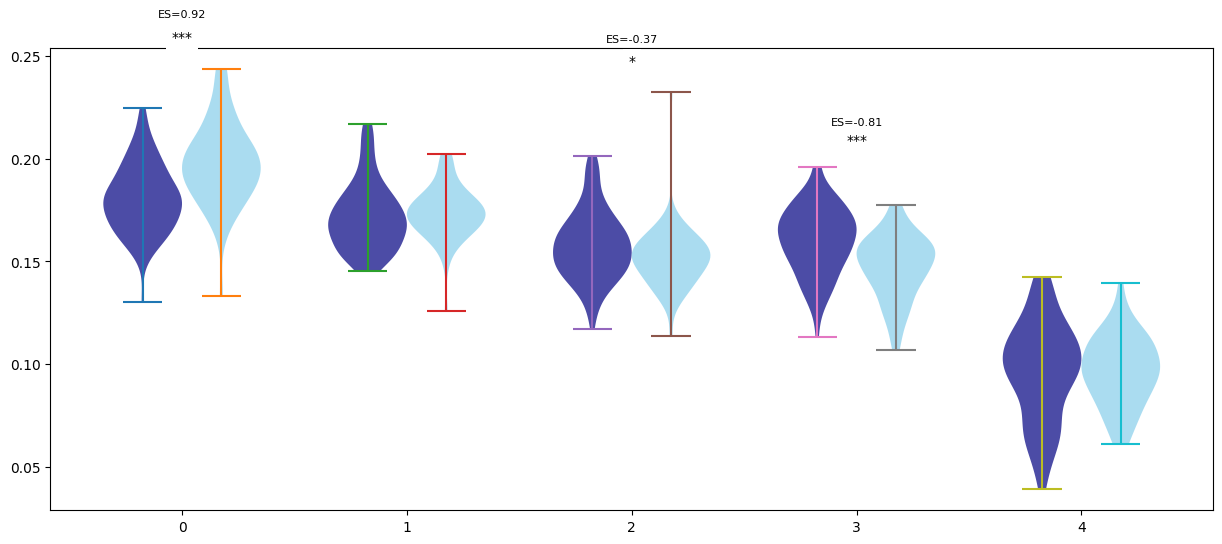

In [35]:
def plot_spectral_comparison(hup_data, mni_data, results_df):
    """
    Create violin plots for spectral features
    """
    # Filter for spectral features
    spectral_features = ['deltaRel_mean', 'thetaRel_mean', 'alphaRel_mean', 
                        'betaRel_mean', 'gammaRel_mean', 'broadRel_mean']
    
    plt.figure(figsize=(15, 6))
    ax = plt.gca()
    
    x = np.arange(len(spectral_features))
    width = 0.35
    
    for i, feature in enumerate(spectral_features):
        # Get data
        hup_means = hup_data.groupby('patient_id')[feature].mean()
        mni_means = mni_data.groupby('patient_id')[feature].mean()
        
        # Get test results
        result_row = results_df[results_df['feature'] == feature].iloc[0]
        p_val = result_row['p_value_fdr']
        effect_size = result_row['effect_size']
        
        # Create violin plots
        v1 = ax.violinplot(mni_means, positions=[i-width/2], widths=width)
        v2 = ax.violinplot(hup_means, positions=[i+width/2], widths=width)
        
        # Style violins
        for pc in v1['bodies']:
            pc.set_facecolor('navy')
            pc.set_alpha(0.7)
        for pc in v2['bodies']:
            pc.set_facecolor('skyblue')
            pc.set_alpha(0.7)
            
        # Add significance markers
        max_val = max(np.max(hup_means), np.max(mni_means))
        if p_val < 0.001:
            sig = '***'
        elif p_val < 0.01:
            sig = '**'
        elif p_val < 0.05:
            sig = '*'
        else:
            sig = 'ns'
            
        if sig != 'ns':
            ax.text(i, max_val*1.05, sig, 
                   ha='center', va='bottom', 
                   bbox=dict(facecolor='white', edgecolor='none'))
            
        # Add effect size
        if sig != 'ns':
            ax.text(i, max_val*1.1, f'ES={effect_size:.2f}',
                   ha='center', va='bottom', fontsize=8)
    
    # Customize axes
    ax.set_ylabel('Relative band power')
    plt.xticks(x, [f.replace('Rel_mean','') for f in spectral_features])
    
    # Add legend
    ax.plot([], [], color='navy', label='MNI')
    ax.plot([], [], color='skyblue', label='HUP')
    ax.legend()
    
    # Add significance legend
    plt.figtext(0.95, 0.95, 
                '* p<0.05\n** p<0.01\n*** p<0.001',
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.title('Spectral power comparison between HUP and MNI cohorts')
    plt.tight_layout()
    plt.show()

def plot_entropy_comparison(hup_data, mni_data, results_df):
    """
    Create violin plots for entropy features
    """
    # Filter for entropy features
    entropy_features = ['entropy_1min_mean', 'entropy_fullts_mean']
    
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    
    x = np.arange(len(entropy_features))
    width = 0.35
    
    for i, feature in enumerate(entropy_features):
        # Get data
        hup_means = hup_data.groupby('patient_id')[feature].mean()
        mni_means = mni_data.groupby('patient_id')[feature].mean()
        
        # Get test results
        result_row = results_df[results_df['feature'] == feature].iloc[0]
        p_val = result_row['p_value_fdr']
        effect_size = result_row['effect_size']
        
        # Create violin plots
        v1 = ax.violinplot(mni_means, positions=[i-width/2], widths=width)
        v2 = ax.violinplot(hup_means, positions=[i+width/2], widths=width)
        
        # Style violins
        for pc in v1['bodies']:
            pc.set_facecolor('navy')
            pc.set_alpha(0.7)
        for pc in v2['bodies']:
            pc.set_facecolor('skyblue')
            pc.set_alpha(0.7)
            
        # Add significance markers
        max_val = max(np.max(hup_means), np.max(mni_means))
        if p_val < 0.001:
            sig = '***'
        elif p_val < 0.01:
            sig = '**'
        elif p_val < 0.05:
            sig = '*'
        else:
            sig = 'ns'
            
        if sig != 'ns':
            ax.text(i, max_val*1.05, sig, 
                   ha='center', va='bottom', 
                   bbox=dict(facecolor='white', edgecolor='none'))
            
        # Add effect size
        if sig != 'ns':
            ax.text(i, max_val*1.1, f'ES={effect_size:.2f}',
                   ha='center', va='bottom', fontsize=8)
    
    # Customize axes
    ax.set_ylabel('Entropy')
    plt.xticks(x, ['1-min', 'Full timeseries'])
    
    # Add legend
    ax.plot([], [], color='navy', label='MNI')
    ax.plot([], [], color='skyblue', label='HUP')
    ax.legend()
    
    # Add significance legend
    plt.figtext(0.95, 0.95, 
                '* p<0.05\n** p<0.01\n*** p<0.001',
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.title('Entropy comparison between HUP and MNI cohorts')
    plt.tight_layout()
    plt.show()

# Usage
results_simple = compare_sites_globally(hup_univar_feats_reg, mni_univar_feats_reg)
plot_spectral_comparison(hup_univar_feats_reg, mni_univar_feats_reg, results_simple)
plot_entropy_comparison(hup_univar_feats_reg, mni_univar_feats_reg, results_simple)